# Testing of Sepsis Data Model 

Snowflake  DEV_DAP_CAE05_DB.SEPSIS   

ED Visits post 1 January 2023

In [1]:
# Import Python Libraries 

import sys
import os
import pickle
import time 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from pandasql import sqldf
import sqlalchemy
import snowflake.connector

import pyodbc

from tqdm import tqdm

import Utilities
import importlib
importlib.reload(Utilities)

import re
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)



# show all dataframe columns 

pd.set_option('display.max_columns', None)

## Connection to SnowFlake 

        con = snowflake.connector.connect(
        account='wt61814.australia-east.privatelink',
        user="iain.bertram@sa.gov.au",
        database="DEV_DAP_CAE05_DB",
        warehouse="DEV_DAP_CAE05_M_WH",
        authenticator="externalbrowser",


In [2]:
# con = Utilities.getConnection()
# con.warehouse

In [3]:
con = snowflake.connector.connect(
        account='wt61814.australia-east.privatelink',
        user="iain.bertram@sa.gov.au",
        database="DEV_DAP_CAE05_DB",
        warehouse="DEV_DAP_CAE05_M_WH",
        authenticator="externalbrowser",
        )

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/bda528f7-fca9-432f-bc98-bd7e90d40906/saml2?SAMLRequest=pZNLc9owFIX%2Fikdd25YfvDSYDA1DQpukJECm052wrokGWXIlGUN%2FfWUDM%2Bki2XSnkc7Vd%2B490vjmWArvANpwJTMUBRh5IHPFuNxlaLOe%2B0PkGUslo0JJyNAJDLqZjA0tRUWmtX2TL%2FC7BmM9d5E0pD3IUK0lUdRwQyQtwRCbk9X08YHEASbUGNDW4dClhBnuWG%2FWViQMm6YJmiRQehfGGOMQj0KnaiVf0DtE9Tmj0sqqXIlrydH19AEiCnHaIpzCEZaXwq9cnkfwGWV7Fhlyv14v%2FeWP1Rp502t3t0qaugS9An3gOWxeHs4GTOvA9qNhlAa0NlZTwakP1Nig0vxALQgu94GRqikE3UOuyqq2DhO4VVgAC4XacTe8xSxD1Z4zfM%2BSkpXf756bb889OBZPVgxxIk716fX0Z8N%2BzvHxbjV3fnY58l6vUcdt1AtjaljINmDrtnDc8%2FHAT%2FAa90gvIfEg6KfpL%2BTNXMBcUttVXrvofAQlz7UyqrBKOuPQudwy2ouHxcAvcjry0yQu%2FG0%2BGvpbNoARZike4X7Yxhij81MinRE9%2Be8BjcP3112e6ZNLbjFbKsHzkzdXuqT242CjIOp2OPOLTkqgpFxMGdNgjAtYCNXcanA%2B

In [4]:
query = '''SELECT  distinct * FROM DEV_DAP_CAE05_DB.SEPSIS.TB_ED_VISIT_TM
WHERE ADMITDTM BETWEEN '2023-01-01' AND '2025-01-01' 
and AGEONADMIT > 17
'''


query='''  
SELECT  distinct 
	JNY.*,
	TRY_TO_TIMESTAMP(LAST_VALUE(LA.COLUMNNEWVALUE) OVER (PARTITION BY LA.CLIENTVISITGUID ORDER BY LA.CREATEDWHEN ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING), 'DD-MON-YYYY HH24:MI') AS "TreatmentStartedDtm",
	timediff(MINUTE,jny.ADMITDTM, TRY_TO_TIMESTAMP(LAST_VALUE(LA.COLUMNNEWVALUE) OVER (PARTITION BY LA.CLIENTVISITGUID ORDER BY LA.CREATEDWHEN ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING), 'DD-MON-YYYY HH24:MI')) AS TreatmentStartedMins,
	TRY_TO_TIMESTAMP(LAST_VALUE(AR.COLUMNNEWVALUE) OVER (PARTITION BY AR.CLIENTVISITGUID ORDER BY AR.CREATEDWHEN ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING), 'DD-MON-YYYY HH24:MI') AS "AdmissionRequestDtm",
	timediff(MINUTE,JNY.ADMITDTM, TRY_TO_TIMESTAMP(LAST_VALUE(AR.COLUMNNEWVALUE) OVER (PARTITION BY AR.CLIENTVISITGUID ORDER BY AR.CREATEDWHEN ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING), 'DD-MON-YYYY HH24:MI')) AS AdmissionRequestMins,
	FIRST_VALUE(OBLP.VALUE) OVER (PARTITION BY JNY.VISITGUID ORDER BY OBLP.CREATEDWHEN ASC  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS FirstTriageValue,
	LAST_VALUE(OBLP.value) OVER (PARTITION BY JNY.VISITGUID ORDER BY OBLP.CREATEDWHEN ASC  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS LastTriageValue,
	FIRST_VALUE(OBLP.CREATEDWHEN) OVER (PARTITION BY JNY.VISITGUID ORDER BY OBLP.CREATEDWHEN ASC  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS FIRSTTRIAGEDTM,
FROM DEV_DAP_CAE05_DB.SEPSIS.TB_ED_VISIT_TM JNY
LEFT JOIN PRD_DAP_EMR_DB.DBO.SXAEDLOCATIONAUDIT AS LA  ON JNY.VISITGUID  = LA.CLIENTVISITGUID AND LA.COLUMNNAME = 'Treatment Commenced' AND LA.COLUMNNEWVALUE IS NOT NULL 
LEFT JOIN PRD_DAP_EMR_DB.DBO.SXAEDLOCATIONAUDIT AS AR  ON jny.VISITGUID  = AR.CLIENTVISITGUID AND AR.COLUMNNAME = 'Admission Request' AND AR.COLUMNNEWVALUE IS NOT NULL 
INNER JOIN PRD_DAP_EMR_DB.DBO.CV3CLIENTDOCUMENT  AS  CD  ON (JNY.CLIENTGUID  = CD.CLIENTGUID  AND JNY.VISITGUID  = CD.CLIENTVISITGUID  AND CD.PATCAREDOCGUID   = 137102020)
INNER JOIN PRD_DAP_EMR_DB.DBO.CV3OBSERVATIONDOCUMENT AS OBDP ON CD.GUID = OBDP.OWNERGUID  -- AND OBDP.Active = 1
INNER JOIN PRD_DAP_EMR_DB.DBO.SCMOBSFSLISTVALUES AS OBLP ON (JNY.CLIENTGUID = OBLP.CLIENTGUID AND OBDP.OBSERVATIONDOCUMENTGUID = OBLP.PARENTGUID  AND OBLP.ACTIVE =1)
INNER JOIN PRD_DAP_EMR_DB.DBO.CV3OBSCATALOGMASTERITEM AS OCMIP ON (OBDP.OBSMASTERITEMGUID=OCMIP.GUID  AND OCMIP.GUID IN  (2759802890) ) -- (17075102890))-- (2759802890) )
WHERE jny.ADMITDTM BETWEEN '2023-01-01' AND '2025-01-01' 
and jny.AGEONADMIT > 17
'''
ed_visits_df = pd.read_sql(query,con)

In [5]:
query_status = ''' 
SELECT 
EDSTAT.CREATEDBY,
EDSTAT.LOCATIONAUDITID,
EDSTAT.CLIENTVISITGUID,
EDSTAT.COLUMNOLDVALUE,
EDSTAT.COLUMNNEWVALUE ,
EDSTAT.CREATEDWHEN 
FROM PRD_DAP_EMR_DB.DBO.SXAEDLOCATIONAUDIT AS EDSTAT 
INNER JOIN PRD_DAP_EMR_DB.DBO.CV3CLIENTVISIT AS CV ON  EDSTAT.CLIENTVISITGUID = CV.GUID  
INNER JOIN DEV_DAP_CAE05_DB.SEPSIS.TB_ED_VISIT_TM JNY ON jny.VISITGUID =CV.GUID 
INNER JOIN PRD_DAP_EMR_DB.DBO.CV3SERVICE AS CS ON CV.SERVICEGUID =  CS.GUID 
INNER JOIN PRD_DAP_EMR_DB.DBO.CV3LOCATION  AS CL ON CV.CURRENTLOCATIONGUID = CL.GUID 
INNER JOIN PRD_DAP_EMR_DB.DBO.CV3LOCATION  AS CLP ON CLP.GUID  = CL.FACILITYGUID 
WHERE jny.ADMITDTM BETWEEN '2023-01-01' AND '2025-01-01' 
and jny.AGEONADMIT > 17
--AND CV.ADMITDTM BETWEEN  '2024-01-01' AND '2025-08-01'
-- AND CV.VISITSTATUS NOT IN ('PRE','CAN')
--AND CLIENTVISITGUID = 2618742800270 AND 
AND COLUMNNEWVALUE  IS NOT NULL  
AND COLUMNNEWVALUE != COLUMNOLDVALUE
AND COLUMNNAME = 'STS'
ORDER BY EDSTAT.CLIENTVISITGUID,EDSTAT.CREATEDWHEN ASC'''

ed_status_df = pd.read_sql(query_status,con)

In [6]:
ed_status_df.head()

,CREATEDBY,LOCATIONAUDITID,CLIENTVISITGUID,COLUMNOLDVALUE,COLUMNNEWVALUE,CREATEDWHEN
0,c03b73a3_klavar01,151355017,2148305200270,WTBS,TIP,2023-01-02 00:55:09.650000+00:00
1,c03b73a3_afarra01,151370403,2148305200270,TIP,DISC,2023-01-02 02:35:45.960000+00:00
2,c03b73a3_csandf01,152540344,2156635500270,WTBS,TIP,2023-01-10 04:03:00.213000+00:00
3,c03b73a3_csandf01,152553738,2156635500270,TIP,DISC,2023-01-10 05:36:18.233000+00:00
4,c03b73a3_csandf01,151542492,2167482100270,WTBS,TIP,2023-01-03 04:17:21.777000+00:00


In [7]:
def qSofa(row):
    value = 0
    resp = (row['Respiration (breaths/min)'])
    gcs = (row['GCS Score'])
    bp = (row['BP Systolic (mm Hg)'])
    IsNaN = pd.isna(resp) and pd.isna(gcs) and pd.isna(bp)
    if IsNaN:
        return None 
        # try:
    if not pd.isna(gcs):
        if int(gcs)<15: value+=1
    if not pd.isna(bp):
        if int(bp)<=100: value+=1
    if not pd.isna(resp):
        if int(resp)>=22:value+=1
        # except:
        # print(gcs,bp,resp)
    return value

def qSirs(row):
    value = 0
    resp = (row['Respiration (breaths/min)'])
    hr = (row['Pulse Rate (beats/min)'])
    wbc = (row['White Cell Count'])
    temp = (row['Temperature (degrees C)'])
    IsNaN = pd.isna(resp) or pd.isna(hr) or pd.isna(temp)
    if IsNaN:
        return None 
    else:
        # try:
        if int(resp)>20: value+=1
        if int(hr)<=90: value+=1
        if not pd.isna(wbc):
            if int(wbc)>=12:value+=1
        if float(temp) >38.:
            value+=1
        elif float(temp)<36.:
            value+=1
        # except:
        # print(gcs,bp,resp)
    return value

def qSirsSevere(row):
    value = 0
    sirs = (row['qSIRS'])
    lact = (row['Lactate'])
    bp = (row['BP Systolic (mm Hg)'])
    IsNaN = pd.isna(sirs)
    if IsNaN:
        return None 
    elif sirs>1:
        # try:
        if not pd.isna(sirs):
            if float(lact)>4: value+=1
        if not pd.isna(bp):
            if int(bp)<=90:value+=1

        # except:
        # print(gcs,bp,resp)
    return value

def timeDiff(first_dtm, second_dtm):
    """
    Calculates the datetime difference between two datetimes  in days. 
    In this case the end date corresponds to ED discharge so if NAT 
    sets to zero as by definition goes straight to ward. 
    
    Parameters
    ----------
    first_dtm: datetime 
        datetime of first event
        
    second_dtm: datetime 
        datetime of second event
    
    Returns
    -------
    diff: float
        time difference measured in days 
    """
    # print(first_dtm,second_dtm)
    if pd.isna(second_dtm) == False:
        if pd.isna(first_dtm) == False:
            diff = (second_dtm - first_dtm)/np.timedelta64(1, 'm')
        else: 
            diff = None
    else: 
        diff = None
    return diff

def timeDiffMortality(first_dtm, second_dtm,ed_dtm):
    """
    Calculates the datetime difference between two datetimes  in days. 
    In this case the end date corresponds to ED discharge so if NAT 
    sets to zero as by definition goes straight to ward. 
    
    Parameters
    ----------
    first_dtm: datetime 
        datetime of first event
        
    second_dtm: datetime 
        datetime of second event
    
    Returns
    -------
    diff: float
        time difference measured in days 
    """
    if pd.isna(second_dtm) == False:
        if pd.isna(ed_dtm) == False:
            diff = (second_dtm - ed_dtm)/np.timedelta64(1, 'D')
        else:
            diff = (second_dtm - first_dtm)/np.timedelta64(1, 'D')
    else: 
        diff = None
    return diff


In [8]:
ed_visits_df.HOSPITAL.unique()

array(['NHS', 'FMC', 'RAH', 'MPH', 'LMH', 'QEH'], dtype=object)

In [9]:
print(len(ed_visits_df.index))

622853


In [10]:
ed_visits_df.ADMITDTM.max()

Timestamp('2024-12-31 13:29:00+0000', tz='UTC')

In [11]:
ed_visits_df.AGEONADMIT.min()

18

In [12]:
query_ip_visits = ''' 
SELECT DISTINCT * FROM DEV_DAP_CAE05_DB.SEPSIS.TB_IP_ASSOCIATED_WITH_ED_PRESENTATION_TMP 
WHERE JOURNEY_ID IN (SELECT  distinct JOURNEY_ID  FROM DEV_DAP_CAE05_DB.SEPSIS.TB_ED_VISIT_TM
WHERE ADMITDTM BETWEEN '2023-01-01' AND '2025-02-01' and AGEONADMIT > 17)  
'''

ip_visits_df = pd.read_sql(query_ip_visits,con)

In [13]:
ip_visits_df.ANY_SEPSIS.value_counts()

ANY_SEPSIS
0    235085
1      6016
Name: count, dtype: int64

For the moment I am requiring at least 3 vital signs from core group to remove the number of entries that are one or two measures

May need to train on TC 3 or more only 

In [14]:
query_vital_signs = ''' 
SELECT  lead(TIME_AFTER_PRESENTATION_MIN) OVER (PARTITION BY CLIENTVISITGUID ORDER BY AUTHOREDDTM) - TIME_AFTER_PRESENTATION_MIN AS TIME_TO_NEXT_VITALS_MINS,
	ROW_NUMBER() OVER (PARTITION BY CLIENTVISITGUID ORDER BY AUTHOREDDTM) vitals_SEQ_BY_visit,
        * FROM (
SELECT 
PulseFlag+TempFlag+BPFlag+O2Flag+respirationflag AS Number_Not_Null,     -- require respiration, O2, BP systolic, pulse, temp AND sedation sedation is most likely to be zero if not filled out Max is 5 
PulseFlag,TempFlag,BPFlag,O2Flag,respirationflag,
CLIENTVISITGUID,	
CLIENTGUID,	
CHARTGUID,	
DATEDIFF(MINUTE , admitdtm,AUTHOREDDTM) AS TIME_AFTER_PRESENTATION_MIN,
admitdtm,
AUTHOREDDTM,
--lag(AUTHOREDDTM ) OVER (PARTITION BY CLIENTVISITGUID ORDER BY AUTHOREDDTM) PREV_authoreddtm,
"Purple zone",
"Red zone",
"Yellow zone",
"Pulse Rate (beats/min)",
"Temperature (degrees C)",
"BP Systolic (mm Hg)",	
"BP Diastolic (mm Hg)",
"O2 Flow (L/min)",
"Sedation Score",
"Resting Pain Score",
"Respiration (breaths/min)",
"Pain: New/Unexpected",
"SpO2 (%)" 
FROM (
SELECT DISTINCT VS.*,
	ED.admitdtm,
 	CASE WHEN "Pulse Rate (beats/min)" IS NULL THEN 0 ELSE 1 END AS PulseFlag,
	CASE WHEN "Temperature (degrees C)" IS NULL THEN 0 ELSE 1 END AS TempFlag,
	CASE WHEN "BP Systolic (mm Hg)" IS NULL THEN 0 ELSE 1 END AS  BPFlag,
	CASE WHEN "SpO2 (%)" IS NULL THEN 0 ELSE 1 END AS O2Flag,
	CASE WHEN "Sedation Score" IS NULL THEN 0 ELSE 1 END AS SedationFlag,
	CASE WHEN "Respiration (breaths/min)" IS NULL THEN 0 ELSE 1 END AS respirationflag
	FROM DEV_DAP_CAE05_DB.SEPSIS.VW__VITAL_SIGNS_BY_ED_VISITGUID_PIVOT AS VS
	INNER JOIN DEV_DAP_CAE05_DB.SEPSIS.TB_ED_VISIT_TM AS ED ON VS.CLIENTVISITGUID = ed.VISITGUID
	WHERE CLIENTVISITGUID  IN (SELECT  distinct VISITGUID   FROM DEV_DAP_CAE05_DB.SEPSIS.TB_ED_VISIT_TM
WHERE ADMITDTM BETWEEN '2023-01-01' AND '2025-01-01' and AGEONADMIT > 17) 
 )ORDER BY CLIENTVISITGUID,AUTHOREDDTM) WHERE Number_Not_Null > 2 
 ORDER BY CLIENTVISITGUID,VITALS_SEQ_BY_VISIT 
'''

vital_signs_df =  pd.read_sql(query_vital_signs,con)

In [15]:
query_gcs = ''' 
SELECT 
ROW_NUMBER() OVER (PARTITION BY CLIENTVISITGUID ORDER BY AUTHOREDDTM) gcs_SEQ_BY_visit, *
FROM (
SELECT DISTINCT 
cd.DOCUMENTNAME, cd.guid AS DocumentGUID, 
ocmi.leftjustifiedlabel, 
od.obsmasteritemguid, 
ocmi.name, 
COALESCE(ob.valuetext, fs.value) as value, 
cd.CREATEDBY, cd.CLIENTVISITGUID, 
v.chartguid, cd.authoreddtm,
od.displaysequence, 
cd.clientguid -- , fsvi.displayname
from PRD_DAP_EMR_DB.DBO.CV3CLIENTDOCUMENT  cd
JOIN PRD_DAP_EMR_DB.DBO.CV3CLIENTVISIT  v on cd.clientvisitguid = v.guid
JOIN PRD_DAP_EMR_DB.DBO.cv3observationdocument od on cd.guid = od.ownerguid and od.active = 1
JOIN PRD_DAP_EMR_DB.DBO.cv3flowsheetversionitem fsvi on fsvi.versionguid = od.flowsheetversionguid
JOIN PRD_DAP_EMR_DB.DBO.CV3OBSCATALOGMASTERITEM ocmi on od.obsmasteritemguid = ocmi.guid
JOIN PRD_DAP_EMR_DB.DBO.cv3observation ob on ob.guid = od.observationguid
LEFT JOIN PRD_DAP_EMR_DB.DBO.SCMOBSFSLISTVALUES fs on od.observationdocumentguid = fs.parentguid
WHERE -- cd.entrytype = 4  and cd.active = 1 and cd.iscanceled = 0 and od.active = 1 
cd.patcaredocguid IN (111102020,137202020,117102020,137102020,59102020)  -- 
AND od.obsmasteritemguid IN (17289502890,19111102890) -- GCS_ICU_Score_CAL, GCS Score FBScore
--ocmi.name ILIKE '%GCS score%'
 AND V.GUID IN (SELECT  distinct visitguid    FROM DEV_DAP_CAE05_DB.SEPSIS.TB_ED_VISIT_TM
WHERE ADMITDTM BETWEEN '2023-01-01' AND '2024-07-01' and AGEONADMIT > 17) )
ORDER BY CLIENTVISITGUID,AUTHOREDDTM, DISPLAYSEQUENCE
'''

gcs_df = pd.read_sql(query_gcs,con)

In [16]:
query_pathology = '''
SELECT DISTINCT 
	j.JOURNEY_ID,
	j.clientguid,
	j.VISITGUID,
	j.CHARTGUID,
	j.ADMITDTM,
	j.DISCHARGEDTM,
    R.CREATEDWHEN  AS  "result_createdwhen",
    R.ACTIVE  AS "result_active", 
    R.GUID AS  "result_observationguid", 
    R.ENTERED as "result_entered", 
    timediff(minute,j.ADMITDTM,r.ENTERED)/60 AS Time_Hours,
    R.STATUS as "result_status",
           R.resultitemguid, 
       R.itemname, 
       R.value, 
       R.unitofmeasure, 
       R.referencelowerlimit,
       R.referenceupperlimit, 
       R.abnormalitycode, 
       R.authorizeddtm, 
       R.clusterid,
       R.typecode,
--     R.hashistory, 
       R.orderguid, 
       R.arrivaldtm, 
       O.requesteddtm AS order_Requesteddtm,
       O.performeddtm AS order_performeddtm,
       o.NAME AS order_name,
       o.ORDERSETNAME 
FROM DEV_DAP_CAE05_DB.SEPSIS.TB_ED_VISIT_TM AS J
LEFT JOIN PRD_DAP_EMR_DB.DBO.CV3BASICOBSERVATION AS R ON j.chartguid = R.chartguid 
AND r.RESULTITEMGUID IN (   
2202601010, -- Lactate Arterial
2215501010, -- Lactate Venous
1588201010, -- white bllod count 
2201301010, -- Base Excess Arterial
2201401010 -- Base Excess Venous	
)
left JOIN PRD_DAP_EMR_DB.DBO.CV3ORDER AS O ON O.GUID = r.ORDERGUID  AND o.typecode = 'Diagnostic'
WHERE (ADMITDTM BETWEEN '2023-01-01' AND '2025-01-01') and AGEONADMIT > 17
ORDER  BY J.JOURNEY_ID ,J.VISITGUID ,r.RESULTITEMGUID

'''

pathology_df = pd.read_sql(query_pathology,con)

In [17]:
pathology_df.head()

,JOURNEY_ID,CLIENTGUID,VISITGUID,CHARTGUID,ADMITDTM,DISCHARGEDTM,result_createdwhen,result_active,result_observationguid,result_entered,TIME_HOURS,result_status,RESULTITEMGUID,ITEMNAME,VALUE,UNITOFMEASURE,REFERENCELOWERLIMIT,REFERENCEUPPERLIMIT,ABNORMALITYCODE,AUTHORIZEDDTM,CLUSTERID,TYPECODE,ORDERGUID,ARRIVALDTM,ORDER_REQUESTEDDTM,ORDER_PERFORMEDDTM,ORDER_NAME,ORDERSETNAME
0,100001201634741464539-105,98221300200,2868082400270,1996982100170,2024-05-03 12:51:00+00:00,2024-05-03 23:03:00+00:00,2024-05-03 14:07:21.313000+00:00,True,8.761470e+13,2024-05-03 14:07:21.057000+00:00,1.266667,F,1.588201e+09,White Cell Count,9.34,x10*9/L,4.00,11.00,U,None,None,N,8.147328e+13,2024-05-03 14:07:21.057000+00:00,2024-05-03 13:57:00+00:00,2024-05-03 13:57:00+00:00,Complete Blood Examination,ED. Pathology - Adult
1,100001201634741464539-107,98221300200,2940591000270,2038100500170,2024-06-18 19:39:00+00:00,2024-06-18 21:41:00+00:00,2024-06-19 04:02:49.183000+00:00,True,9.027516e+13,2024-06-19 04:02:48.993000+00:00,8.383333,F,1.588201e+09,White Cell Count,8.53,x10*9/L,4.00,11.00,U,None,None,N,8.455029e+13,2024-06-19 04:02:48.993000+00:00,2024-06-19 03:59:00+00:00,2024-06-19 03:59:00+00:00,Complete Blood Examination,None
2,100001801634741464539-102,98221900200,2898196600270,2014050100170,2024-05-22 12:42:00+00:00,2024-05-23 07:18:00+00:00,2024-05-24 23:20:45.520000+00:00,True,8.885867e+13,2024-05-24 23:20:45.360000+00:00,58.633333,F,1.588201e+09,White Cell Count,8.56,x10*9/L,4.00,11.00,U,None,None,N,8.285135e+13,2024-05-24 23:20:45.360000+00:00,2024-05-24 21:57:00+00:00,2024-05-24 21:57:00+00:00,Complete Blood Examination,COMMON. Lab Orders
3,100001801634741464539-102,98221900200,2898196600270,2014050100170,2024-05-22 12:42:00+00:00,2024-05-23 07:18:00+00:00,2024-05-22 21:15:47.147000+00:00,True,8.873515e+13,2024-05-22 21:15:46.980000+00:00,8.550000,F,1.588201e+09,White Cell Count,19.06,x10*9/L,4.00,11.00,H,None,None,N,8.273757e+13,2024-05-22 21:15:46.980000+00:00,2024-05-22 19:48:00+00:00,2024-05-22 19:48:00+00:00,Complete Blood Examination,None
4,100001801634741464539-102,98221900200,2898196600270,2014050100170,2024-05-22 12:42:00+00:00,2024-05-23 07:18:00+00:00,2024-05-24 06:18:09.750000+00:00,True,8.882015e+13,2024-05-24 06:18:09.393000+00:00,41.600000,F,1.588201e+09,White Cell Count,10.11,x10*9/L,4.00,11.00,U,None,None,N,8.285137e+13,2024-05-24 06:18:09.393000+00:00,2024-05-24 02:30:00+00:00,2024-05-24 02:30:00+00:00,Complete Blood Examination,None


In [18]:
gcs_df.rename(columns={'VALUE':'GCS Score'},inplace=True )

In [19]:
gcs_df

,GCS_SEQ_BY_VISIT,DOCUMENTNAME,DOCUMENTGUID,LEFTJUSTIFIEDLABEL,OBSMASTERITEMGUID,NAME,GCS Score,CREATEDBY,CLIENTVISITGUID,CHARTGUID,AUTHOREDDTM,DISPLAYSEQUENCE,CLIENTGUID
0,1,ED Nursing Assessment-- (RAH),25378784202040,GCS Score,19111102890,GCS Score FBScore,15,"Varghese, Alby",2182962500270,1595031500170,2022-12-31 13:48:00+00:00,103,296428600200
1,2,-ED Flowsheet,25379096702040,None,17289502890,GCS_ICU_Score_CAL,15,"Varghese, Alby",2182962500270,1595031500170,2022-12-31 15:04:00+00:00,375,296428600200
2,3,-ED Flowsheet,25379629802040,None,17289502890,GCS_ICU_Score_CAL,15,"Murphy, Sarah",2182962500270,1595031500170,2022-12-31 16:03:00+00:00,375,296428600200
3,4,-ED Flowsheet,25381210702040,None,17289502890,GCS_ICU_Score_CAL,15,"How, Michael",2182962500270,1595031500170,2022-12-31 18:39:00+00:00,375,296428600200
4,1,-ED Flowsheet,25379422002040,None,17289502890,GCS_ICU_Score_CAL,15,"Semmler, Adele",2182966300270,1595035100170,2022-12-31 15:41:00+00:00,375,94672300200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423517,8,-ED Flowsheet,42758215002040,None,17289502890,GCS_ICU_Score_CAL,15,"Cheng, Nga",2959772400270,2048832900170,2024-06-30 21:59:00+00:00,399,47315100200
1423518,1,-ED Flowsheet,42753034402040,None,17289502890,GCS_ICU_Score_CAL,15,"Parker, Michael",2959772500270,2048833000170,2024-06-30 16:52:00+00:00,399,139489500200
1423519,2,-ED Flowsheet,42755169502040,None,17289502890,GCS_ICU_Score_CAL,15,"Harrison, Cory",2959772500270,2048833000170,2024-06-30 19:08:00+00:00,399,139489500200
1423520,3,-ED Flowsheet,42757161702040,None,17289502890,GCS_ICU_Score_CAL,15,"Parker, Michael",2959772500270,2048833000170,2024-06-30 20:56:00+00:00,399,139489500200


In [20]:
queryICU = ''' 
SELECT viit.* FROM DEV_DAP_CAE05_DB.SEPSIS.VW_IP_ICU_TIME AS viit
WHERE viit.VISITGUID IN (SELECT DISTINCT visitguid FROM DEV_DAP_CAE05_DB.SEPSIS.TB_IP_ASSOCIATED_WITH_ED_PRESENTATION_TMP where AGEONADMIT > 17)
'''
icu_df = pd.read_sql(queryICU,con)

In [21]:
icu_df.head()

,VISITGUID,ICU_HOURS
0,2395379000270,208
1,2425011900270,99
2,2562938400270,57
3,3142552900270,91
4,2971388400270,53


In [22]:
gcs_df.head()

,GCS_SEQ_BY_VISIT,DOCUMENTNAME,DOCUMENTGUID,LEFTJUSTIFIEDLABEL,OBSMASTERITEMGUID,NAME,GCS Score,CREATEDBY,CLIENTVISITGUID,CHARTGUID,AUTHOREDDTM,DISPLAYSEQUENCE,CLIENTGUID
0,1,ED Nursing Assessment-- (RAH),25378784202040,GCS Score,19111102890,GCS Score FBScore,15,"Varghese, Alby",2182962500270,1595031500170,2022-12-31 13:48:00+00:00,103,296428600200
1,2,-ED Flowsheet,25379096702040,None,17289502890,GCS_ICU_Score_CAL,15,"Varghese, Alby",2182962500270,1595031500170,2022-12-31 15:04:00+00:00,375,296428600200
2,3,-ED Flowsheet,25379629802040,None,17289502890,GCS_ICU_Score_CAL,15,"Murphy, Sarah",2182962500270,1595031500170,2022-12-31 16:03:00+00:00,375,296428600200
3,4,-ED Flowsheet,25381210702040,None,17289502890,GCS_ICU_Score_CAL,15,"How, Michael",2182962500270,1595031500170,2022-12-31 18:39:00+00:00,375,296428600200
4,1,-ED Flowsheet,25379422002040,None,17289502890,GCS_ICU_Score_CAL,15,"Semmler, Adele",2182966300270,1595035100170,2022-12-31 15:41:00+00:00,375,94672300200


In [23]:
vital_signs_df.head()

,TIME_TO_NEXT_VITALS_MINS,VITALS_SEQ_BY_VISIT,NUMBER_NOT_NULL,PULSEFLAG,TEMPFLAG,BPFLAG,O2FLAG,RESPIRATIONFLAG,CLIENTVISITGUID,CLIENTGUID,CHARTGUID,TIME_AFTER_PRESENTATION_MIN,ADMITDTM,AUTHOREDDTM,Purple zone,Red zone,Yellow zone,Pulse Rate (beats/min),Temperature (degrees C),BP Systolic (mm Hg),BP Diastolic (mm Hg),O2 Flow (L/min),Sedation Score,Resting Pain Score,Respiration (breaths/min),Pain: New/Unexpected,SpO2 (%)
0,76.0,1,5,1,1,1,1,1,2182962500270,296428600200,1595031500170,18,2022-12-31 13:30:00+00:00,2022-12-31 13:48:00+00:00,None,None,None,65,35.8,102,41,None,None,None,16,None,100
1,59.0,2,4,1,0,1,1,1,2182962500270,296428600200,1595031500170,94,2022-12-31 13:30:00+00:00,2022-12-31 15:04:00+00:00,0,0,0,62,None,111,42,None,0,None,15,None,96
2,156.0,3,5,1,1,1,1,1,2182962500270,296428600200,1595031500170,153,2022-12-31 13:30:00+00:00,2022-12-31 16:03:00+00:00,0,0,0,63,36.5,102,37,None,0,None,14,None,100
3,NaN,4,5,1,1,1,1,1,2182962500270,296428600200,1595031500170,309,2022-12-31 13:30:00+00:00,2022-12-31 18:39:00+00:00,0,0,0,78,36.3,100,38,None,0,None,20,None,98
4,64.0,1,5,1,1,1,1,1,2182966300270,94672300200,1595035100170,18,2022-12-31 14:19:00+00:00,2022-12-31 14:37:00+00:00,None,None,None,65,37.1,121,62,None,None,None,20,None,95


In [24]:
print(len(vital_signs_df.index))

2281581


NUMBER_NOT_NULL
5    437424
4     68585
3     18334
Name: count, dtype: int64


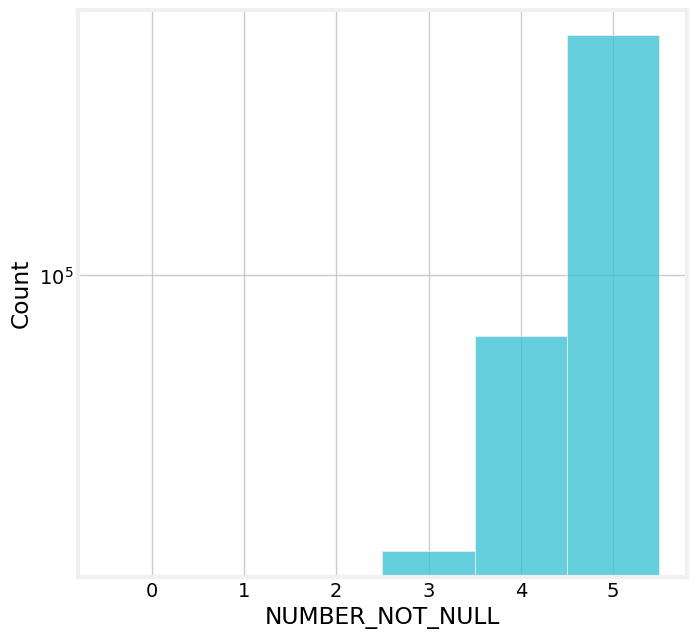

In [25]:
from matplotlib.colors import to_rgba

plt.style.use('./CEIH.mplstyle')
color_dict = {0: to_rgba('#32C0D2', 1),
                1: to_rgba("#E0B165", 1),}

tmp_df = vital_signs_df.loc[vital_signs_df.VITALS_SEQ_BY_VISIT==1].copy()
print(tmp_df.NUMBER_NOT_NULL.value_counts())
fig, ax = plt.subplots(figsize=(7, 7))
sns.histplot(data=tmp_df,x="NUMBER_NOT_NULL",binrange=[-0.5,5.5],binwidth=1,label="Number of Vital Signs Recorded")
plt.yscale('log')

In [26]:
query_client = ''' 
 SELECT GUID AS clientguid,
 GENDERCODE ,
 RACECODE ,
 DECEASEDDTM 
 FROM PRD_DAP_EMR_DB.DBO.CV3CLIENT AS C
 WHERE C.GUID IN (SELECT  distinct CLIENTGUID    FROM DEV_DAP_CAE05_DB.SEPSIS.TB_ED_VISIT_TM
WHERE ADMITDTM BETWEEN '2023-01-01' AND '2024-07-01')
'''

client_df = pd.read_sql(query_client,con)

In [27]:
colums_to_keep = ['JOURNEY_ID','CLIENTGUID','VISITGUID', 'CHARTGUID', 'ADMITDTM','DISCHARGEDTM','AGEONADMIT','TRIAGE_CATEGORY','DISCHARGEDISPOSITION','HOSPITAL','FIRSTTRIAGEVALUE']

In [28]:
ip_visits_df['IP_ED_Overlap'] = ip_visits_df.apply(lambda row: timeDiff(row['PRE_DISCHARGEDTM'],row['DISCHARGEDTM']), axis=1)

In [29]:
dropidx = ip_visits_df[ip_visits_df.CURRENTLOCATION.str.contains('Admin')].index   #.CURRENTLOCATION.unique()

In [30]:
ip_visits_clean_df = ip_visits_df.drop(dropidx)

In [31]:
dropidx_short = ip_visits_clean_df[(ip_visits_clean_df.IP_ED_Overlap<60)&(~ip_visits_clean_df.DISCHARGEDISPOSITION.str.contains('Died'))].index

In [32]:
ip_visits_clean_df.drop(dropidx_short,inplace=True)

In [33]:
ip_cols_to_keeep  = [ 'PRIMARY_SEPSIS', 'ANY_SEPSIS', 'JOURNEY_ID','VISITGUID', 'CHARTGUID', 'ADMITDTM','DISCHARGEDTM','PRE_ADMITDTM',	'PRE_DISCHARGEDTM', 'ADMITDTM','DISCHARGEDTM','AGEONADMIT','MORTALITY_INDICATOR','DISCHARGEDISPOSITION','ALLCHARDIAGNOSIS','CURRENTLOCATION','IP_ED_Overlap','HOSPITAL']

In [34]:
vitals_to_keep = ['VITALS_SEQ_BY_VISIT', 'NUMBER_NOT_NULL', 'CLIENTVISITGUID',
       'AUTHOREDDTM', 'Purple zone', 'Red zone',
       'Yellow zone', 'Pulse Rate (beats/min)', 'Temperature (degrees C)',
       'BP Systolic (mm Hg)', 'BP Diastolic (mm Hg)', 'O2 Flow (L/min)',
       'Sedation Score', 'Resting Pain Score', 'Respiration (breaths/min)',
       'Pain: New/Unexpected', 'SpO2 (%)']

In [35]:
ed_visits_df.head()

,ED_SEQ_BY_JOURNEY,JOURNEY_ID,JOURNEY_ID_OLD,CLIENTGUID,SAUHI,RANK,EPISODE_ID,VISITGUID,CHARTGUID,ADMITDTM,DISCHARGEDTM,DISCHARGEDISPOSITION,PRE_VISITGUID,PRE_CHARTGUID,PRE_ADMITDTM,PRE_DISCHARGEDTM,PRE_DISCHARGEDISPOSITION,DISCHARGELOCATION,VISITIDCODE,AGEONADMIT,DOB,AGE,SUBURB,POSTCODE,HOMELHN,MH_CATCHMENT,SEIFA_RELATIVE_DISADVANTAGE,IRSD_SCORE,IRSD_DECILE,IRSAD_SCORE,IRSAD_DECILE,IER_SCORE,IER_DECILE,IEO_SCORE,IEO_DECILE,IRSD_GROUP,USUALACCOMODATIONTYPE,HOSPITAL,HOSPITALNAME,METROCOUNTRYFLAG,TYPECODE,CARELEVELCODE,CURRENTLOCATIONGUID,CURRENTLOCATION,WARD,WARD_DESC,WARD_TYPE,WARD_CAPACITY,REHAB_WARD_TYPE,REHAB_HITH_FLAG,ADMISSIONREQUESTDATETIME,GROUPCODE,SERVICEDESCRIPTION,SUBGROUPCODE,SUBGROUP_DESCRIPTION,CLINICCODE,CLINICNAME,ADMITSOURCE,ADMISSIONCATEGORY,EPISODEOFCARE,PATIENTCATEGORY,ADMISSIONTYPE,ADMISSIONELECTION,SOURCEOFREFERRAL,LOSNIGHTS,LOSHOUR,LOS_GROUPS,MORTALITY_INDICATOR,SAH_DIAGNOSIS,DIAGNOSISCODE,ED_CODE_2,ED_CODE_3,DIAGNOSIS_CODE_DESC,ALLDIAGNOSIS,ALLCHARDIAGNOSIS,ALLDIAGNOSISHOSPITAL,ALLCHARDIAGNOSISHOSPITAL,PROCEDURECODE,PROCEDURE_CODE_DESC,ALLPROCEDURES,LEGALSTATUSCODE,LEGALSTATUSDESCRIPTION,DRG,MDC,ECCS,NWAU,TILESEPISODEOFCARE,TILESDISCHARGEDISPOSITION,ICUVENTHOURS,TOTALMVHOURS,DICTIONARYREASONS,MODE_OF_ARRIVAL,MODE_OF_ARRIVAL_TYPE,TRIAGE_CATEGORY,SAAS_ORG_EVENT_NUMBER,SAAS_ORG_DISPATCH_NUMBER,ED_ORG_EVENT_NUMBER,ED_ORG_DISPATCH_NUMBER,SAAS_INCIDENT_PRIORITY,DESTINATIONARRIVALDATETIME,TRIAGEASSESSMENTDESCRIPTION,TRIAGEASSESSMENTSUBDESCRIPTION,LOCATIONCOMMONPLACENAME,LOCATIONPRIMARYCOMMONPLACENAME,LOCATIONCOMMONPLACETYPE,DESTINATIONCOMMONPLACENAME,DESTINATIONPRIMARYCOMMONPLACENAME,DESTINATIONCOMMONPLACETYPE,DISPOSITIONTYPECODE,DISPOSITIONTYPEDESCRIPTION,DESTINATIONFLAG,PATIENTHANDOVERDATETIME,AROC_RECORD_TYPE,AROC_NOTE_FLAG,MH_WARD_TYPE,TREATED_IN_MH_WARD,DEMENTIA_FLAG,MENTAL_HEALTH_ECT_TREATMENT_FLAG,MENTAL_HEALTH_ECT_JOURNEY_FLAG,JOURNEY_ACCURACY,JOURNEY_HOSPITAL_TYPE,FREQUENT_VISITOR_FLAG,MENTAL_HEALTH_FLAG_BYDIAGNOSIS,MENTAL_HEALTH_FLAG_BYJOURNEY,CLOZAPINE_FLAG_BYJOURNEY,MENTAL_HEALTH_FLAG_BYJOURNEY_MHWARD,REHAB_FLAG_BYJOURNEY,EDI_REHAB_AGECARE_FLAG_BYJOURNEY,MAINTENANCE_FLAG_BYVISIT,REHAB_FLAG_BYVISIT,GEM_FLAG_BYVISIT,ED_24HRS_IP_ADMISSION_FLAG,PATIENT_ED_24HRS_IP_ADMISSION_FLAG,CHRONIC_DIAGNOSIS,ONSITE_WARD_FLAG,EDI_REHAB_AGECARE_FLAG_BYVISIT,TreatmentStartedDtm,TREATMENTSTARTEDMINS,AdmissionRequestDtm,ADMISSIONREQUESTMINS,FIRSTTRIAGEVALUE,LASTTRIAGEVALUE,FIRSTTRIAGEDTM
0,1,22454301634741464539-117,1206580 - 17,20674400200,100006650541,1,17,2371812900270,1708559100170,2023-05-24 10:28:00+00:00,2023-05-24 13:00:00+00:00,ED02 Admit as Inpatient,2.349430e+12,1.695312e+12,2023-05-11 02:43:00+00:00,2023-05-11 07:00:00+00:00,IP Home,None,112835296,50,1973-02-02,52,HACKHAM WEST,5163,SALHN,Southern Adelaide LHN,851.0,906,1,876,1,939,2,873,1,Low,Private Residence,NHS,Noarlunga Hospital,M,Emergency,Emergency,265400610,NHS-ED-SWB,ED,None,None,NaN,None,0,2023-05-24 12:38:00+00:00,NHS-EMERG,NHS Emergency,None,NHS Emergency,None,Emergency,ED Self-Family-Friends,Emergency,None,None,None,None,ED Self-Family-Friends,0,3,Same day,Didnt Die,"Complication of surgical and medical care, uns...",T889,None,T889,Comp surgical & medical care unsp,None,None,None,None,None,None,None,3,Voluntary,None,None,None,None,None,None,None,None,None,Private Car,Non Ambulance,4,None,None,None,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,NaT,None,Not Applicable,Other,N,0,N,N,Accurate Journey,All Metro,Y,N,N,N,N,N,N,N,N,N,N,N,Not Chronic,Y,N,2023-05-24 21:15:00+09:30,77.0,2023-05-24 12:38:00+00:00,130.0,4,4,2023-05-24 10:32:41.703000+00:00
1,1,32322171454741464540-101,3864116 - 1,305422700200,100010467775,1,1,2357888800270,1700353700170,2023-05-15 11:25:00+00:00,2023-05-15 15:53:00+00:00,ED01 Discharged Home,NaN,NaN,NaT,NaT,None,None,112734884,48,1975-10-11,50,SHEIDOW PARK,5158,SALHN,Southern Adelaide LHN,1066.0,1055,8,1016,7,1051,8,999,7,High,Private Residence,FMC,Flinders Medical Centre,M,Emergency,Emergency,22183006

In [36]:
ed_visits_df.loc[ed_visits_df.TRIAGE_CATEGORY!=ed_visits_df.LASTTRIAGEVALUE][['TRIAGE_CATEGORY','LASTTRIAGEVALUE','FIRSTTRIAGEVALUE']]

,TRIAGE_CATEGORY,LASTTRIAGEVALUE,FIRSTTRIAGEVALUE
1850,3,5,3
2356,3,2,2
7174,TBA,2,2
14112,4,3,4
41169,4,3,3
...,...,...,...
585041,3,4,4
596697,4,3,3
619337,3,4,4
620223,3,5,3


In [37]:
gcs_to_keep = ['CLIENTVISITGUID','GCS Score']

In [38]:
temp_0_df = ed_visits_df[colums_to_keep].copy()

temp_1_df = pd.merge(temp_0_df,client_df,left_on='CLIENTGUID',right_on='CLIENTGUID',how='left')
temp_2_df = pd.merge(temp_1_df,ip_visits_clean_df[ip_cols_to_keeep],left_on='JOURNEY_ID',right_on='JOURNEY_ID',suffixes=(None,'_IP'),how='left')
tmp_df = vital_signs_df.loc[vital_signs_df.VITALS_SEQ_BY_VISIT==1].copy()
temp_3_df = pd.merge(temp_2_df,tmp_df[vitals_to_keep],left_on='VISITGUID',right_on='CLIENTVISITGUID',suffixes=(None,'_Vitals'),how='left')
tmp_df = gcs_df.loc[gcs_df.GCS_SEQ_BY_VISIT==1][gcs_to_keep].copy()
temp_3_df = pd.merge(temp_3_df,tmp_df,left_on='VISITGUID',right_on='CLIENTVISITGUID',how='left')
temp_3_df = pd.merge(temp_3_df,icu_df,left_on='VISITGUID_IP',right_on='VISITGUID',how='left',suffixes=(None,'_icu'))

sepsis_df = temp_3_df
sepsis_df.drop(columns=['CLIENTVISITGUID_x','CLIENTVISITGUID_y','VISITGUID_icu'],axis=1,inplace=True)


sepsis_df['PRIMARY_SEPSIS'] = sepsis_df['PRIMARY_SEPSIS'].fillna(0)
sepsis_df['ANY_SEPSIS'] = sepsis_df['ANY_SEPSIS'].fillna(0)



In [39]:
int_columns = [ 'CLIENTGUID', 'VISITGUID', 'CHARTGUID',  'AGEONADMIT', 
        'PRIMARY_SEPSIS', 'ANY_SEPSIS',
       'VISITGUID_IP', 'CHARTGUID_IP',
       'AGEONADMIT_IP', 
       'VITALS_SEQ_BY_VISIT', 'NUMBER_NOT_NULL',
       'Purple zone', 'Red zone', 'Yellow zone',
       'Pulse Rate (beats/min)', 
       'BP Systolic (mm Hg)', 'BP Diastolic (mm Hg)', 
       'Sedation Score', 'Resting Pain Score', 'Respiration (breaths/min)',
       'SpO2 (%)', 'GCS Score']


float_cols = ['Temperature (degrees C)', 'O2 Flow (L/min)',]

In [40]:
# row = sepsis_df.iloc[0]
# timeDiff(row['PRE_DISCHARGEDTM'],row['ADMITDTM_IP'].values[0])

In [41]:
# sepsis_df['IP_ED_Overlap'] = sepsis_df.apply(lambda row: timeDiff(row['PRE_DISCHARGEDTM'],row['DISCHARGEDTM_IP'].values[0]), axis=1)

In [42]:
# sepsis_df[sepsis_df.IP_ED_Overlap<60]

In [43]:
sepsis_df.head()

,JOURNEY_ID,CLIENTGUID,VISITGUID,CHARTGUID,ADMITDTM,DISCHARGEDTM,AGEONADMIT,TRIAGE_CATEGORY,DISCHARGEDISPOSITION,HOSPITAL,FIRSTTRIAGEVALUE,GENDERCODE,RACECODE,DECEASEDDTM,PRIMARY_SEPSIS,ANY_SEPSIS,VISITGUID_IP,CHARTGUID_IP,ADMITDTM_IP,DISCHARGEDTM_IP,PRE_ADMITDTM,PRE_DISCHARGEDTM,ADMITDTM_IP,DISCHARGEDTM_IP,AGEONADMIT_IP,MORTALITY_INDICATOR,DISCHARGEDISPOSITION_IP,ALLCHARDIAGNOSIS,CURRENTLOCATION,IP_ED_Overlap,HOSPITAL_IP,VITALS_SEQ_BY_VISIT,NUMBER_NOT_NULL,AUTHOREDDTM,Purple zone,Red zone,Yellow zone,Pulse Rate (beats/min),Temperature (degrees C),BP Systolic (mm Hg),BP Diastolic (mm Hg),O2 Flow (L/min),Sedation Score,Resting Pain Score,Respiration (breaths/min),Pain: New/Unexpected,SpO2 (%),GCS Score,ICU_HOURS
0,22454301634741464539-117,20674400200,2371812900270,1708559100170,2023-05-24 10:28:00+00:00,2023-05-24 13:00:00+00:00,50,4,ED02 Admit as Inpatient,NHS,4,Male,Not Aboriginal-TSI,NaT,0.0,0.0,2.371862e+12,1.708559e+12,2023-05-24 12:38:00+00:00,2023-05-25 23:42:00+00:00,2023-05-24 10:28:00+00:00,2023-05-24 13:00:00+00:00,2023-05-24 12:38:00+00:00,2023-05-25 23:42:00+00:00,50.0,Didnt Die,IP Home,S602 T793 B956 W22 Y929 U739 Z8643 U862 U833,NHS-COLL-42-A,2082.0,NHS,1.0,4.0,2023-05-24 10:36:00+00:00,0,0,1,81,None,141,80,None,0,None,22,None,98,15,NaN
1,32322171454741464540-101,305422700200,2357888800270,1700353700170,2023-05-15 11:25:00+00:00,2023-05-15 15:53:00+00:00,48,2,ED01 Discharged Home,FMC,2,Male,Not Aboriginal-TSI,NaT,0.0,0.0,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,2023-05-15 11:42:00+00:00,None,None,None,64,36.4,105,72,0,None,None,18,None,98,15,NaN
2,94649201634741464539-104,92869300200,2362264900270,1702873500170,2023-05-18 01:11:00+00:00,2023-05-18 05:23:00+00:00,54,2,ED01 Discharged Home,RAH,2,Female,Not Aboriginal-TSI,NaT,0.0,0.0,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,2023-05-18 01:39:00+00:00,None,None,None,79,None,138,98,None,None,None,18,None,100,15,NaN
3,17481101634741464539-106,15701200200,2361766700270,1702599800170,2023-05-17 12:18:00+00:00,2023-05-17 16:07:00+00:00,22,2,ED02 Admit as Inpatient,FMC,2,Male,Not Aboriginal-TSI,NaT,0.0,0.0,2.361820e+12,1.702600e+12,2023-05-17 15:59:00+00:00,2023-06-14 00:59:00+00:00,2023-05-17 12:18:00+00:00,2023-05-17 16:07:00+00:00,2023-05-17 15:59:00+00:00,2023-06-14 00:59:00+00:00,22.0,Didnt Die,IP Home,J690 B965 W78 Y9209 E876 K117 U833 U794,FMC-4A-20-20,39412.0,FMC,1.0,5.0,2023-05-17 12:34:00+00:00,0,2,0,131,37,126,86,None,None,None,30,None,95,10,613.0
4,77505903434741464538-102,7572600200,2365833300270,1705094400170,2023-05-20 12:31:00+00:00,2023-05-20 17:06:00+00:00,68,3,ED01 Discharged Home,FMC,3,Female,Not Aboriginal-TSI,NaT,0.0,0.0,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,2023-05-20 13:46:00+00:00,0,0,0,98,35.9,154,65,None,0,3,18,no,99,15,NaN


In [44]:
sepsis_df['AGERANGE_ON_ADMIT2'] = np.where(sepsis_df.AGEONADMIT>84,'85+',
                                                np.where(sepsis_df.AGEONADMIT>64,'65 - 84',
                                                np.where(sepsis_df.AGEONADMIT>34,'35 - 64','<35')))
age_range_order = [ '<35','35 - 64', '65 - 84', '85+']
sepsis_df['AGERANGE_ON_ADMIT2'] = pd.Categorical(sepsis_df['AGERANGE_ON_ADMIT2'],categories=age_range_order,ordered=True)

In [45]:
cols = ['Pulse Rate (beats/min)',
       'Temperature (degrees C)', 
       'BP Systolic (mm Hg)',
       # 'BP Diastolic (mm Hg)', 
    #    'O2 Flow (L/min)', 
    #    'Sedation Score',
       # 'Resting Pain Score', 
       'Respiration (breaths/min)',
       # 'Pain: New/Unexpected', 
       'SpO2 (%)',]
sepsis_df['number_of_NaNs'] = sepsis_df[cols].isna().sum(1)

In [46]:
for col in int_columns:
    # print(col)
    sepsis_df[col] = sepsis_df[col].astype('Int64')


In [47]:
sepsis_df.loc[sepsis_df.PRIMARY_SEPSIS==1].head()

,JOURNEY_ID,CLIENTGUID,VISITGUID,CHARTGUID,ADMITDTM,DISCHARGEDTM,AGEONADMIT,TRIAGE_CATEGORY,DISCHARGEDISPOSITION,HOSPITAL,FIRSTTRIAGEVALUE,GENDERCODE,RACECODE,DECEASEDDTM,PRIMARY_SEPSIS,ANY_SEPSIS,VISITGUID_IP,CHARTGUID_IP,ADMITDTM_IP,DISCHARGEDTM_IP,PRE_ADMITDTM,PRE_DISCHARGEDTM,ADMITDTM_IP,DISCHARGEDTM_IP,AGEONADMIT_IP,MORTALITY_INDICATOR,DISCHARGEDISPOSITION_IP,ALLCHARDIAGNOSIS,CURRENTLOCATION,IP_ED_Overlap,HOSPITAL_IP,VITALS_SEQ_BY_VISIT,NUMBER_NOT_NULL,AUTHOREDDTM,Purple zone,Red zone,Yellow zone,Pulse Rate (beats/min),Temperature (degrees C),BP Systolic (mm Hg),BP Diastolic (mm Hg),O2 Flow (L/min),Sedation Score,Resting Pain Score,Respiration (breaths/min),Pain: New/Unexpected,SpO2 (%),GCS Score,ICU_HOURS,AGERANGE_ON_ADMIT2,number_of_NaNs
17,61415903434741464538-102,5963600200,2218082000270,1616584900170,2023-01-30 06:04:00+00:00,2023-01-30 23:34:00+00:00,56,2,ED02 Admit as Inpatient,RAH,2,Male,Not Aboriginal-TSI,2024-03-30 13:30:00+00:00,1,1,2218696000270,1616584900170,2023-01-30 13:50:00+00:00,2023-02-05 05:21:00+00:00,2023-01-30 06:04:00+00:00,2023-01-30 23:34:00+00:00,2023-01-30 13:50:00+00:00,2023-02-05 05:21:00+00:00,56,Didnt Die,IP Home,A418 R073 E833 E109,RAH-7EF-7E016-01,7547.0,RAH,1,5,2023-01-30 06:54:00+00:00,<NA>,<NA>,<NA>,82,37,111,70,None,<NA>,<NA>,16,None,97,15,NaN,35 - 64,0
100,45314001634741464539-103,43534100200,2370067900270,1707591100170,2023-05-23 22:25:00+00:00,2023-05-24 04:17:00+00:00,69,1,ED02 Admit as Inpatient,LMH,1,Male,Not Aboriginal-TSI,2023-05-26 14:30:00+00:00,1,1,2371098000270,1707591100170,2023-05-24 04:18:00+00:00,2023-05-27 10:29:00+00:00,2023-05-23 22:25:00+00:00,2023-05-24 04:17:00+00:00,2023-05-24 04:18:00+00:00,2023-05-27 10:29:00+00:00,69,Died during visit,IP Died - No Autopsy,A411 R572 L0313 L033 N390 B962 N179 N184 I500 ...,LMH-ICU-19-19,4692.0,LMH,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,78.0,65 - 84,5
272,32328671454741464540-101,305487700200,2359837300270,1701517600170,2023-05-16 14:07:00+00:00,2023-05-17 14:13:00+00:00,92,2,ED02 Admit as Inpatient,LMH,2,Female,Not Aboriginal-TSI,2023-05-21 14:30:00+00:00,1,1,2361805400270,1701517600170,2023-05-16 23:29:00+00:00,2023-05-22 04:35:00+00:00,2023-05-16 14:07:00+00:00,2023-05-17 14:13:00+00:00,2023-05-16 23:29:00+00:00,2023-05-22 04:35:00+00:00,92,Died during visit,IP Died - No Autopsy,A410 F058 K566 K590 I489 N179 E86 E871 E835 R9...,LMH-Ward 1E-14-14,6622.0,LMH,1,5,2023-05-16 14:55:00+00:00,<NA>,<NA>,<NA>,102,36.3,119,93,None,<NA>,<NA>,20,None,92,15,NaN,85+,0
1123,41172701634741464539-129,39392800200,2273192900270,1649233000170,2023-03-10 23:28:00+00:00,2023-03-11 02:42:00+00:00,76,1,ED02 Admit as Inpatient,QEH,1,Male,Not Aboriginal-TSI,NaT,1,1,2273305200270,1649233000170,2023-03-11 01:02:00+00:00,2023-03-17 13:00:00+00:00,2023-03-10 23:28:00+00:00,2023-03-11 02:42:00+00:00,2023-03-11 01:02:00+00:00,2023-03-17 13:00:00+00:00,76,Didnt Die,IP Other Health Care Accomm,A419 R572 L0313 B956 N179 N184 K590 K567 B353 ...,QEH-N1B-28-02,9258.0,QEH,1,4,2023-03-11 01:53:00+00:00,0,1,1,112,38,<NA>,<NA>,2,0,<NA>,26,None,95,15,73.0,65 - 84,1
1350,27628581454741464540-103,258486800200,2781623200270,1947798200170,2024-03-07 01:18:00+00:00,2024-03-07 06:55:00+00:00,89,1,ED02 Admit as Inpatient,MPH,1,Female,Not Aboriginal-TSI,2024-03-26 13:30:00+00:00,1,1,2782743900270,1947798200170,2024-03-07 10:00:00+00:00,2024-03-09 01:15:00+00:00,2024-03-07 01:18:00+00:00,2024-03-07 06:55:00+00:00,2024-03-07 10:00:00+00:00,2024-03-09 01:15:00+00:00,89,Died within 30 days discharge,IP Res Care Facility-Usual Res,A419 N390 R296 U862 U821 U791,MPH-SSGMU-15-15,2540.0,MPH,1,5,2024-03-07 05:56:00+00:00,0,0,1,110,35.9,154,95,None,0,<NA>,19,None,98,14,NaN,85+,0


In [48]:
sepsis_df['Respiration (breaths/min)'].unique()

<IntegerArray>
[  22,   18,   30,   26,   14,   17, <NA>,   16,   20,   15,   24,   19,   27,
   21,   28,   35,   36,   34,   12,   29,   25,   32,   10,   23,   33,   38,
   13,   40,    0,   50,   44,   89,   45,    8,   46,   41,   31,   43,   39,
    6,   42,    9,   48,   47,   11,   85,   37,   58,    7,   60,   76,   94,
   67,   54,   97,   52,   96,   65,   78,   98,    5,    1,    4,   81,   99,
   70,   64,   61,   56,    2,   51,   86,   63,   49,   88,   53,   68,   72,
   74,   95,   57,   92,   80,   59,   62,   87,   75,   93,   55,   84,   90]
Length: 91, dtype: Int64

In [49]:
# sepsis_df['qSOFA'] = np.where(sepsis_df['Respiration (breaths/min)']>=22) #np.where(sepsis_df['GCS Score']<15,1,0) #+
sepsis_df['qSOFA'] =    sepsis_df.apply(lambda row: qSofa(row), axis = 1)


In [50]:
sepsis_df['qSOFA'].value_counts(dropna=False)

qSOFA
0.0    420987
NaN     99013
1.0     90247
2.0     11783
3.0       823
Name: count, dtype: int64

In [51]:
sepsis_df[(~sepsis_df.DECEASEDDTM.isna())&(sepsis_df.PRIMARY_SEPSIS==1)].MORTALITY_INDICATOR.value_counts()

MORTALITY_INDICATOR
Died during visit                423
Didnt Die                        368
Died within 7 days discharge     110
Died within 30 days discharge     43
Died within 14 days discharge     28
Name: count, dtype: int64

In [52]:
sepsis_df[~(sepsis_df.NUMBER_NOT_NULL.isna())&(sepsis_df.PRIMARY_SEPSIS==1)].MORTALITY_INDICATOR.value_counts()  #.MORTALITY_INDICATOR.value_counts()

MORTALITY_INDICATOR
Didnt Die                        1292
Died during visit                 368
Died within 7 days discharge      102
Died within 30 days discharge      43
Died within 14 days discharge      27
Name: count, dtype: int64

## Pathology Tests 

- White Blood Count 
- Lactate Level 


In [53]:
# white_blood_count_df =  
tmp = pathology_df.loc[(pathology_df.RESULTITEMGUID==1588201010)&(pathology_df.TIME_HOURS<36)].copy()
tmp.dropna(subset=['VALUE'],inplace=True)
tmp['VALUE'] = pd.to_numeric(tmp['VALUE'])
white_blood_count = tmp.sort_values(['VISITGUID','TIME_HOURS']).groupby('VISITGUID').head(1).copy()
white_blood_count.rename(columns={'VALUE':'White Cell Count'},inplace=True)

In [54]:
tmp = pathology_df.loc[(pathology_df.RESULTITEMGUID.isin([2202601010,2215501010]))&(pathology_df.TIME_HOURS<36)].copy()
tmp.dropna(subset=['VALUE'],inplace=True)
tmp['VALUE'] = tmp['VALUE'].replace({'>30.0':'30.0','<0.2':'0.1'})
tmp['VALUE'] = pd.to_numeric(tmp['VALUE'])
lactate_blood_gas = tmp.sort_values(['VISITGUID','TIME_HOURS']).groupby('VISITGUID').head(1).copy()
lactate_blood_gas.rename(columns={'VALUE':'Lactate'},inplace=True)

In [55]:
# dups = lactate_blood_gas.VISITGUID.value_counts()
# dups2 = dups[dups.gt(1)]
# dups2

In [56]:
sepsis_path_df = pd.merge(sepsis_df,white_blood_count[['VISITGUID','White Cell Count']],left_on='VISITGUID',right_on='VISITGUID',how='left')
sepsis_path_df = pd.merge(sepsis_path_df,lactate_blood_gas[['VISITGUID','Lactate']],left_on='VISITGUID',right_on='VISITGUID',how='left')
sepsis_df = sepsis_path_df.copy()

In [57]:
sepsis_df.columns

Index(['JOURNEY_ID', 'CLIENTGUID', 'VISITGUID', 'CHARTGUID', 'ADMITDTM',
       'DISCHARGEDTM', 'AGEONADMIT', 'TRIAGE_CATEGORY', 'DISCHARGEDISPOSITION',
       'HOSPITAL', 'FIRSTTRIAGEVALUE', 'GENDERCODE', 'RACECODE', 'DECEASEDDTM',
       'PRIMARY_SEPSIS', 'ANY_SEPSIS', 'VISITGUID_IP', 'CHARTGUID_IP',
       'ADMITDTM_IP', 'DISCHARGEDTM_IP', 'PRE_ADMITDTM', 'PRE_DISCHARGEDTM',
       'ADMITDTM_IP', 'DISCHARGEDTM_IP', 'AGEONADMIT_IP',
       'MORTALITY_INDICATOR', 'DISCHARGEDISPOSITION_IP', 'ALLCHARDIAGNOSIS',
       'CURRENTLOCATION', 'IP_ED_Overlap', 'HOSPITAL_IP',
       'VITALS_SEQ_BY_VISIT', 'NUMBER_NOT_NULL', 'AUTHOREDDTM', 'Purple zone',
       'Red zone', 'Yellow zone', 'Pulse Rate (beats/min)',
       'Temperature (degrees C)', 'BP Systolic (mm Hg)',
       'BP Diastolic (mm Hg)', 'O2 Flow (L/min)', 'Sedation Score',
       'Resting Pain Score', 'Respiration (breaths/min)',
       'Pain: New/Unexpected', 'SpO2 (%)', 'GCS Score', 'ICU_HOURS',
       'AGERANGE_ON_ADMIT2', 'numbe

In [58]:
sepsis_df['qSIRS'] =    sepsis_df.apply(lambda row: qSirs(row), axis = 1)


In [59]:
sepsis_df['qSIRS'].value_counts(dropna=False)

qSIRS
1.0    252880
NaN    171591
2.0    105126
0.0     74794
3.0     17113
4.0      1349
Name: count, dtype: int64

In [60]:
sepsis_df['qSIRS_Severe'] =    sepsis_df.apply(lambda row: qSirsSevere(row), axis = 1)


In [61]:
sepsis_df['qSIRS_Severe'].value_counts(dropna=False)

qSIRS_Severe
0.0    447929
NaN    171591
1.0      3170
2.0       163
Name: count, dtype: int64

In [62]:
sepsis_df.columns

Index(['JOURNEY_ID', 'CLIENTGUID', 'VISITGUID', 'CHARTGUID', 'ADMITDTM',
       'DISCHARGEDTM', 'AGEONADMIT', 'TRIAGE_CATEGORY', 'DISCHARGEDISPOSITION',
       'HOSPITAL', 'FIRSTTRIAGEVALUE', 'GENDERCODE', 'RACECODE', 'DECEASEDDTM',
       'PRIMARY_SEPSIS', 'ANY_SEPSIS', 'VISITGUID_IP', 'CHARTGUID_IP',
       'ADMITDTM_IP', 'DISCHARGEDTM_IP', 'PRE_ADMITDTM', 'PRE_DISCHARGEDTM',
       'ADMITDTM_IP', 'DISCHARGEDTM_IP', 'AGEONADMIT_IP',
       'MORTALITY_INDICATOR', 'DISCHARGEDISPOSITION_IP', 'ALLCHARDIAGNOSIS',
       'CURRENTLOCATION', 'IP_ED_Overlap', 'HOSPITAL_IP',
       'VITALS_SEQ_BY_VISIT', 'NUMBER_NOT_NULL', 'AUTHOREDDTM', 'Purple zone',
       'Red zone', 'Yellow zone', 'Pulse Rate (beats/min)',
       'Temperature (degrees C)', 'BP Systolic (mm Hg)',
       'BP Diastolic (mm Hg)', 'O2 Flow (L/min)', 'Sedation Score',
       'Resting Pain Score', 'Respiration (breaths/min)',
       'Pain: New/Unexpected', 'SpO2 (%)', 'GCS Score', 'ICU_HOURS',
       'AGERANGE_ON_ADMIT2', 'numbe

In [63]:
diagnosis_code_df = pd.read_csv("Original_Code/_DIM_Diagnosis_Codes__202405071653.csv")
# display(diagnosis_code_df.head())
diagnosisList = [
            "A021",
            "A227",
            "A267",
            "A327",
            "A40",
            "A400",
            "A401",
            "A402",
            "A403",
            "A408",
            "A409",
            "A41",
            "A410",
            "A411",
            "A412",
            "A413",
            "A414",
            "A415",
            "A4150",
            "A4151",
            "A4152",
            "A4158",
            "A418",
            "A419",
            "A427",
            "B377",
            "O85",

            "R651" ]

# 2023 Data Sample 

In [64]:
sepsis_2023_sample_df = sepsis_df.loc[(sepsis_df.DISCHARGEDTM<'2024-01-01')&(sepsis_df.DISCHARGEDTM>'2023-01-01')].copy()

In [65]:
num_presentations_2023 = len(sepsis_2023_sample_df.index)

In [66]:
sepsis_2023_sample_df.NUMBER_NOT_NULL.value_counts( dropna=False)

NUMBER_NOT_NULL
5       215525
<NA>     52233
4        35798
3         9273
Name: count, dtype: Int64

In [67]:
sepsis_2023_sample_df.dropna(subset=['NUMBER_NOT_NULL'],inplace=True)

In [68]:
num_presentations_2023_Three_VS = len(sepsis_2023_sample_df.index)

In [69]:
print("There are {} ED presentations in 2023 of which {} presentations have at least 3 vital signs of interest.".format(num_presentations_2023,num_presentations_2023_Three_VS))

There are 312829 ED presentations in 2023 of which 260596 presentations have at least 3 vital signs of interest.


In [70]:
59468/331667 

0.17930032231123386

In [71]:
print(sepsis_2023_sample_df.ANY_SEPSIS.value_counts(dropna=False))
print(sepsis_2023_sample_df.PRIMARY_SEPSIS.value_counts(dropna=False))


ANY_SEPSIS
0    258039
1      2557
Name: count, dtype: Int64
PRIMARY_SEPSIS
0    259676
1       920
Name: count, dtype: Int64


In [72]:
print(len(diagnosisList))
# temp_df = df_verification.loc[df_verification.SepsisFlag==1].copy()
temp_df  = sepsis_2023_sample_df.loc[sepsis_2023_sample_df['ANY_SEPSIS']==1].copy()
for diag in diagnosisList:
    desc = diagnosis_code_df[diagnosis_code_df["diagnosis_code"]==diag].diagnosis_code_desc.values[0]
    diagnosis_count = temp_df.loc[temp_df.ALLCHARDIAGNOSIS.str.contains(diag)].ANY_SEPSIS.sum()
    print("{}\t{}\t{}".format(diag,diagnosis_count,desc))

28
A021	5	Salmonella sepsis
A227	0	Anthrax sepsis
A267	0	Erysipelothrix sepsis
A327	0	Listerial sepsis
A40	197	Streptococcal sepsis
A400	38	Sepsis dt streptococcus group A
A401	25	Sepsis dt streptococcus group B
A402	52	Sepsis dt streptococcus group D
A403	22	Sepsis dt Streptococcus pneumoniae
A408	61	Other streptococcal sepsis
A409	4	Streptococcal sepsis unspecified
A41	2349	Other sepsis
A410	106	Sepsis due to Staphylococcus aureus
A411	39	Sepsis dt other spec staphylococcus
A412	8	Sepsis due to unsp staphylococcus
A413	2	Sepsis dt Haemophilus influenzae
A414	14	Sepsis due to anaerobes
A415	405	Sepsis dt oth & unsp gram neg organisms
A4150	12	Sepsis dt unsp Gram neg organisms
A4151	262	Sepsis dt Escherichia coli (E coli)
A4152	45	Sepsis due to Pseudomonas
A4158	100	Sepsis dt other gram neg organisms
A418	86	Other specified sepsis
A419	1710	Sepsis, unspecified
A427	1	Actinomycotic sepsis
B377	22	Candidal sepsis
O85	11	Puerperal sepsis
R651	0	SIRS infect origin w ac organ failure


# 2024 Metropolitan Verification Dataset

Check that the number of ED presentations is corect. 2024 much lower than 2023????

In [73]:
sepsis_2024_sample_df = sepsis_df.loc[(sepsis_df.DISCHARGEDTM<'2025-01-01')&(sepsis_df.DISCHARGEDTM>'2024-01-01')].copy()
num_presentations_2024 = len(sepsis_2024_sample_df.index)
print(sepsis_2024_sample_df.NUMBER_NOT_NULL.value_counts( dropna=False))
sepsis_2024_sample_df.dropna(subset=['NUMBER_NOT_NULL'],inplace=True)
num_presentations_2024_Three_VS = len(sepsis_2024_sample_df.index)
print("There are {} ED presentations in 2024 of which {} presentations have at least 3 vital signs of interest.\n".format(num_presentations_2024,num_presentations_2024_Three_VS))

print(sepsis_2024_sample_df.ANY_SEPSIS.value_counts(dropna=False))
print(sepsis_2024_sample_df.PRIMARY_SEPSIS.value_counts(dropna=False))

print(28036 /166517 )

NUMBER_NOT_NULL
5       221774
<NA>     46250
4        32759
3         9061
Name: count, dtype: Int64
There are 309844 ED presentations in 2024 of which 263594 presentations have at least 3 vital signs of interest.

ANY_SEPSIS
0    261148
1      2446
Name: count, dtype: Int64
PRIMARY_SEPSIS
0    262682
1       912
Name: count, dtype: Int64
0.1683671937399785


In [74]:
sepsis_2024_sample_df.columns

Index(['JOURNEY_ID', 'CLIENTGUID', 'VISITGUID', 'CHARTGUID', 'ADMITDTM',
       'DISCHARGEDTM', 'AGEONADMIT', 'TRIAGE_CATEGORY', 'DISCHARGEDISPOSITION',
       'HOSPITAL', 'FIRSTTRIAGEVALUE', 'GENDERCODE', 'RACECODE', 'DECEASEDDTM',
       'PRIMARY_SEPSIS', 'ANY_SEPSIS', 'VISITGUID_IP', 'CHARTGUID_IP',
       'ADMITDTM_IP', 'DISCHARGEDTM_IP', 'PRE_ADMITDTM', 'PRE_DISCHARGEDTM',
       'ADMITDTM_IP', 'DISCHARGEDTM_IP', 'AGEONADMIT_IP',
       'MORTALITY_INDICATOR', 'DISCHARGEDISPOSITION_IP', 'ALLCHARDIAGNOSIS',
       'CURRENTLOCATION', 'IP_ED_Overlap', 'HOSPITAL_IP',
       'VITALS_SEQ_BY_VISIT', 'NUMBER_NOT_NULL', 'AUTHOREDDTM', 'Purple zone',
       'Red zone', 'Yellow zone', 'Pulse Rate (beats/min)',
       'Temperature (degrees C)', 'BP Systolic (mm Hg)',
       'BP Diastolic (mm Hg)', 'O2 Flow (L/min)', 'Sedation Score',
       'Resting Pain Score', 'Respiration (breaths/min)',
       'Pain: New/Unexpected', 'SpO2 (%)', 'GCS Score', 'ICU_HOURS',
       'AGERANGE_ON_ADMIT2', 'numbe

In [75]:
print(len(diagnosisList))
# temp_df = df_verification.loc[df_verification.SepsisFlag==1].copy()
temp_df  = sepsis_2024_sample_df.loc[sepsis_2024_sample_df['ANY_SEPSIS']==1].copy()
for diag in diagnosisList:
    desc = diagnosis_code_df[diagnosis_code_df["diagnosis_code"]==diag].diagnosis_code_desc.values[0]
    diagnosis_count = temp_df.loc[temp_df.ALLCHARDIAGNOSIS.str.contains(diag)].ANY_SEPSIS.sum()
    print("{}\t{}\t{}".format(diag,diagnosis_count,desc))

28
A021	4	Salmonella sepsis
A227	0	Anthrax sepsis
A267	0	Erysipelothrix sepsis
A327	0	Listerial sepsis
A40	186	Streptococcal sepsis
A400	25	Sepsis dt streptococcus group A
A401	29	Sepsis dt streptococcus group B
A402	46	Sepsis dt streptococcus group D
A403	31	Sepsis dt Streptococcus pneumoniae
A408	47	Other streptococcal sepsis
A409	13	Streptococcal sepsis unspecified
A41	2256	Other sepsis
A410	97	Sepsis due to Staphylococcus aureus
A411	37	Sepsis dt other spec staphylococcus
A412	2	Sepsis due to unsp staphylococcus
A413	1	Sepsis dt Haemophilus influenzae
A414	9	Sepsis due to anaerobes
A415	349	Sepsis dt oth & unsp gram neg organisms
A4150	9	Sepsis dt unsp Gram neg organisms
A4151	234	Sepsis dt Escherichia coli (E coli)
A4152	27	Sepsis due to Pseudomonas
A4158	86	Sepsis dt other gram neg organisms
A418	70	Other specified sepsis
A419	1698	Sepsis, unspecified
A427	0	Actinomycotic sepsis
B377	16	Candidal sepsis
O85	9	Puerperal sepsis
R651	0	SIRS infect origin w ac organ failure


## Sepsis Cases 

In [76]:
temp_df = sepsis_df[(sepsis_df.PRIMARY_SEPSIS==1)].copy()
temp_df['MORTALITY_INDICATOR'] =  pd.Categorical(temp_df['MORTALITY_INDICATOR'] )


temp_df["MortalityAfterAdmissionDays"] = temp_df.apply(lambda row: timeDiffMortality(row['ADMITDTM'],row['DECEASEDDTM'], row['ADMITDTM']), axis = 1)
temp_df['Died30DaysAfterAdmission'] = 0
temp_df.loc[(temp_df.MortalityAfterAdmissionDays<31), 'Died30DaysAfterAdmission'] = 1

groupedBy = 'FIRSTTRIAGEVALUE'
# groupedBy = 'HOSPITAL'

EoC = temp_df[['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
EoC.rename(columns={"VISITGUID": "EoC"},inplace=True)

age = temp_df[['AGEONADMIT',groupedBy]].groupby(groupedBy,observed=False ).mean().round(1)
age.rename(columns={"AGEONADMIT": "Average Age"},inplace=True)

vitals_available = temp_df.loc[~temp_df.NUMBER_NOT_NULL.isna()][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
vitals_available.rename(columns={"VISITGUID": ">2 vital signs available"},inplace=True)

qsofa = temp_df.loc[temp_df.qSOFA>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsofa.rename(columns={"VISITGUID": "qSOFA Flag"},inplace=True)


qsirs = temp_df.loc[temp_df.qSIRS>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsirs.rename(columns={"VISITGUID": "SIRS Flag"},inplace=True)

qsirs_severe = temp_df.loc[temp_df.qSIRS_Severe>=1][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsirs_severe.rename(columns={"VISITGUID": "SIRS Severe"},inplace=True)

purple =  temp_df.loc[temp_df['Purple zone']>=1][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
purple.rename(columns={"VISITGUID": "Purple >0 Flag"},inplace=True)

red =  temp_df.loc[temp_df['Red zone']>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
red.rename(columns={"VISITGUID": "Red >1 Flag"},inplace=True)

icu  = temp_df[temp_df.ICU_HOURS>0][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
icu.rename(columns={"VISITGUID": "ICU Stay"},inplace=True)

diedDuringVisit = temp_df[temp_df.MORTALITY_INDICATOR=='Died during visit'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False).count().fillna(0)
diedDuringVisit.rename(columns={"VISITGUID": "Died as IP"},inplace=True)

died30 = temp_df[temp_df.MortalityAfterAdmissionDays<31][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False).count().fillna(0)
died30.rename(columns={"VISITGUID": "Died 30 days after admission"},inplace=True)

summaryTable = pd.concat((EoC, age,vitals_available,qsofa,qsirs,qsirs_severe,purple,red,icu,diedDuringVisit,died30), axis=1) #, diedInVisit,diedIn7, diedIn14, diedIn30,fractionDied), axis=1)
summaryTable.fillna(0,inplace=True)

summaryTable.loc['Total/Mean'] = summaryTable.sum().round(0)
summaryTable.loc['Total/Mean', 'Average Age'] = temp_df['AGEONADMIT'].mean().round(1)


for col in ['EoC', '>2 vital signs available', 'qSOFA Flag',  "SIRS Flag","SIRS Severe", 'Purple >0 Flag', 'Red >1 Flag', 'ICU Stay', 'Died as IP','Died 30 days after admission']:
        summaryTable[col] = summaryTable[col].astype('Int64')

if groupedBy == 'TRIAGE_CATEGORY':
        summaryTable.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        summaryTable.index.rename("Hospital", inplace=True)
display(summaryTable)


# display(vitals_available)

# temp_0_df

,EoC,Average Age,>2 vital signs available,qSOFA Flag,SIRS Flag,SIRS Severe,Purple >0 Flag,Red >1 Flag,ICU Stay,Died as IP,Died 30 days after admission
FIRSTTRIAGEVALUE,,,,,,,,,,,
1,316,74.7,213,112,132,65,98,36,146,124,148
2,1131,73.3,980,355,598,169,263,168,356,235,284
3,576,70.7,554,95,292,44,61,51,140,86,109
4,92,68.8,84,10,42,5,9,5,17,20,21
5,1,36.0,1,0,1,0,0,0,0,0,0
Total/Mean,2116,72.6,1832,572,1065,283,431,260,659,465,562


In [77]:
summaryTable.columns


Index(['EoC', 'Average Age', '>2 vital signs available', 'qSOFA Flag',
       'SIRS Flag', 'SIRS Severe', 'Purple >0 Flag', 'Red >1 Flag', 'ICU Stay',
       'Died as IP', 'Died 30 days after admission'],
      dtype='object')

In [78]:
temp_df = sepsis_2023_sample_df.loc[sepsis_2023_sample_df['ANY_SEPSIS']==1].copy()
temp_df['MORTALITY_INDICATOR'] =  pd.Categorical(temp_df['MORTALITY_INDICATOR'] )


temp_df["MortalityAfterAdmissionDays"] = temp_df.apply(lambda row: timeDiffMortality(row['ADMITDTM'],row['DECEASEDDTM'], row['ADMITDTM']), axis = 1)
temp_df['Died30DaysAfterAdmission'] = 0
temp_df.loc[(temp_df.MortalityAfterAdmissionDays<31), 'Died30DaysAfterAdmission'] = 1

groupedBy = 'FIRSTTRIAGEVALUE'
# groupedBy = 'HOSPITAL'
# groupedBy ='number_of_NaNs'

EoC = temp_df[['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
EoC.rename(columns={"VISITGUID": "EoC"},inplace=True)

age = temp_df[['AGEONADMIT',groupedBy]].groupby(groupedBy,observed=False ).mean().round(1)
age.rename(columns={"AGEONADMIT": "Average Age"},inplace=True)

vitals_available = temp_df.loc[~temp_df.NUMBER_NOT_NULL.isna()][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
vitals_available.rename(columns={"VISITGUID": ">2 vital signs available"},inplace=True)

qsofa = temp_df.loc[temp_df.qSOFA>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsofa.rename(columns={"VISITGUID": "qSOFA Flag"},inplace=True)

qsirs = temp_df.loc[temp_df.qSIRS>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsirs.rename(columns={"VISITGUID": "SIRS Flag"},inplace=True)

qsirs_severe = temp_df.loc[temp_df.qSIRS_Severe>=1][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsirs_severe.rename(columns={"VISITGUID": "SIRS Severe"},inplace=True)

purple =  temp_df.loc[temp_df['Purple zone']>=1][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
purple.rename(columns={"VISITGUID": "Purple >0 Flag"},inplace=True)

red =  temp_df.loc[temp_df['Red zone']>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
red.rename(columns={"VISITGUID": "Red >1 Flag"},inplace=True)

icu  = temp_df[temp_df.ICU_HOURS>0][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
icu.rename(columns={"VISITGUID": "ICU Stay"},inplace=True)

diedDuringVisit = temp_df[temp_df.MORTALITY_INDICATOR=='Died during visit'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False).count().fillna(0)
diedDuringVisit.rename(columns={"VISITGUID": "Died as IP"},inplace=True)

died30 = temp_df[temp_df.MortalityAfterAdmissionDays<31][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False).count().fillna(0)
died30.rename(columns={"VISITGUID": "Died 30 days after admission"},inplace=True)

summaryTable = pd.concat((EoC, age,vitals_available,qsofa,qsirs,qsirs_severe,purple,red), axis=1) #, diedInVisit,diedIn7, diedIn14, diedIn30,fractionDied), axis=1)
summaryTable.fillna(0,inplace=True)

summaryTable.loc['Total/Mean'] = summaryTable.sum().round(0)
summaryTable.loc['Total/Mean', 'Average Age'] = temp_df['AGEONADMIT'].mean().round(1)


for col in ['EoC', '>2 vital signs available', 'qSOFA Flag',  "SIRS Flag","SIRS Severe", 'Purple >0 Flag', 'Red >1 Flag']:
        summaryTable[col] = summaryTable[col].astype('Int64')

if groupedBy in ['TRIAGE_CATEGORY','FIRSTTRIAGEVALUE']:
        summaryTable.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        summaryTable.index.rename("Hospital", inplace=True)
display(summaryTable)
print(summaryTable.to_markdown())
# display(vitals_available)

# temp_0_df

,EoC,Average Age,>2 vital signs available,qSOFA Flag,SIRS Flag,SIRS Severe,Purple >0 Flag,Red >1 Flag
Triage Category,,,,,,,,
1,239,74.2,239,142,132,45,80,34
2,1235,71.9,1235,458,711,163,246,162
3,945,70.7,945,171,484,52,74,52
4,133,66.2,133,12,57,1,10,6
5,5,42.4,5,0,1,0,0,0
Total/Mean,2557,71.3,2557,783,1385,261,410,254


| Triage Category   |   EoC |   Average Age |   >2 vital signs available |   qSOFA Flag |   SIRS Flag |   SIRS Severe |   Purple >0 Flag |   Red >1 Flag |
|:------------------|------:|--------------:|---------------------------:|-------------:|------------:|--------------:|-----------------:|--------------:|
| 1                 |   239 |          74.2 |                        239 |          142 |         132 |            45 |               80 |            34 |
| 2                 |  1235 |          71.9 |                       1235 |          458 |         711 |           163 |              246 |           162 |
| 3                 |   945 |          70.7 |                        945 |          171 |         484 |            52 |               74 |            52 |
| 4                 |   133 |          66.2 |                        133 |           12 |          57 |             1 |               10 |             6 |
| 5                 |     5 |          42.4 |                         

In [79]:
summaryTable = pd.concat((EoC, age,icu,diedDuringVisit,died30), axis=1) #, diedInVisit,diedIn7, diedIn14, diedIn30,fractionDied), axis=1)
summaryTable.fillna(0,inplace=True)

summaryTable.loc['Total/Mean'] = summaryTable.sum().round(0)
summaryTable.loc['Total/Mean', 'Average Age'] = temp_df['AGEONADMIT'].mean().round(1)


for col in ['EoC',  'ICU Stay', 'Died as IP','Died 30 days after admission']:
        summaryTable[col] = summaryTable[col].astype('Int64')

if groupedBy in ['TRIAGE_CATEGORY','FIRSTTRIAGEVALUE']:
        summaryTable.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        summaryTable.index.rename("Hospital", inplace=True)
display(summaryTable)
print(summaryTable.to_markdown())

,EoC,Average Age,ICU Stay,Died as IP,Died 30 days after admission
Triage Category,,,,,
1,239,74.2,89,81,109
2,1235,71.9,400,208,292
3,945,70.7,247,135,176
4,133,66.2,39,23,26
5,5,42.4,2,0,0
Total/Mean,2557,71.3,777,447,603


| Triage Category   |   EoC |   Average Age |   ICU Stay |   Died as IP |   Died 30 days after admission |
|:------------------|------:|--------------:|-----------:|-------------:|-------------------------------:|
| 1                 |   239 |          74.2 |         89 |           81 |                            109 |
| 2                 |  1235 |          71.9 |        400 |          208 |                            292 |
| 3                 |   945 |          70.7 |        247 |          135 |                            176 |
| 4                 |   133 |          66.2 |         39 |           23 |                             26 |
| 5                 |     5 |          42.4 |          2 |            0 |                              0 |
| Total/Mean        |  2557 |          71.3 |        777 |          447 |                            603 |


In [80]:
temp_df = sepsis_2024_sample_df.loc[sepsis_2024_sample_df['ANY_SEPSIS']==1].copy()
temp_df['MORTALITY_INDICATOR'] =  pd.Categorical(temp_df['MORTALITY_INDICATOR'] )


temp_df["MortalityAfterAdmissionDays"] = temp_df.apply(lambda row: timeDiffMortality(row['ADMITDTM'],row['DECEASEDDTM'], row['ADMITDTM']), axis = 1)
temp_df['Died30DaysAfterAdmission'] = 0
temp_df.loc[(temp_df.MortalityAfterAdmissionDays<31), 'Died30DaysAfterAdmission'] = 1

groupedBy = 'FIRSTTRIAGEVALUE'
# groupedBy = 'HOSPITAL'
# groupedBy = 'AGERANGE_ON_ADMIT2'

EoC = temp_df[['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
EoC.rename(columns={"VISITGUID": "EoC"},inplace=True)

age = temp_df[['AGEONADMIT',groupedBy]].groupby(groupedBy,observed=False ).mean().round(1)
age.rename(columns={"AGEONADMIT": "Average Age"},inplace=True)

vitals_available = temp_df.loc[~temp_df.NUMBER_NOT_NULL.isna()][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
vitals_available.rename(columns={"VISITGUID": ">2 vital signs available"},inplace=True)

qsofa = temp_df.loc[temp_df.qSOFA>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsofa.rename(columns={"VISITGUID": "qSOFA Flag"},inplace=True)


qsirs = temp_df.loc[temp_df.qSIRS>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsirs.rename(columns={"VISITGUID": "SIRS Flag"},inplace=True)

qsirs_severe = temp_df.loc[temp_df.qSIRS_Severe>=1][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsirs_severe.rename(columns={"VISITGUID": "SIRS Severe"},inplace=True)

purple =  temp_df.loc[temp_df['Purple zone']>=1][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
purple.rename(columns={"VISITGUID": "Purple >0 Flag"},inplace=True)

red =  temp_df.loc[temp_df['Red zone']>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
red.rename(columns={"VISITGUID": "Red >1 Flag"},inplace=True)

icu  = temp_df[temp_df.ICU_HOURS>0][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
icu.rename(columns={"VISITGUID": "ICU Stay"},inplace=True)

diedDuringVisit = temp_df[temp_df.MORTALITY_INDICATOR=='Died during visit'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False).count().fillna(0)
diedDuringVisit.rename(columns={"VISITGUID": "Died as IP"},inplace=True)

died30 = temp_df[temp_df.MortalityAfterAdmissionDays<31][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False).count().fillna(0)
died30.rename(columns={"VISITGUID": "Died 30 days after admission"},inplace=True)

summaryTable = pd.concat((EoC, age,vitals_available,qsofa,qsirs,qsirs_severe,purple,red), axis=1) #, diedInVisit,diedIn7, diedIn14, diedIn30,fractionDied), axis=1)
summaryTable.fillna(0,inplace=True)

summaryTable.loc['Total/Mean'] = summaryTable.sum().round(0)
summaryTable.loc['Total/Mean', 'Average Age'] = temp_df['AGEONADMIT'].mean().round(1)


for col in ['EoC', '>2 vital signs available', 'qSOFA Flag',  "SIRS Flag","SIRS Severe", 'Purple >0 Flag', 'Red >1 Flag']:
        summaryTable[col] = summaryTable[col].astype('Int64')

if groupedBy in ['TRIAGE_CATEGORY','FIRSTTRIAGEVALUE']:
        summaryTable.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        summaryTable.index.rename("Hospital", inplace=True)
display(summaryTable)
print(summaryTable.to_markdown())
# display(vitals_available)

# temp_0_df

,EoC,Average Age,>2 vital signs available,qSOFA Flag,SIRS Flag,SIRS Severe,Purple >0 Flag,Red >1 Flag
Triage Category,,,,,,,,
1,241,75.3,241,107,150,70,126,41
2,1210,71.9,1210,324,722,157,324,207
3,838,70.1,838,93,407,62,109,61
4,157,69.8,157,17,79,15,20,9
Total/Mean,2446,71.5,2446,541,1358,304,579,318


| Triage Category   |   EoC |   Average Age |   >2 vital signs available |   qSOFA Flag |   SIRS Flag |   SIRS Severe |   Purple >0 Flag |   Red >1 Flag |
|:------------------|------:|--------------:|---------------------------:|-------------:|------------:|--------------:|-----------------:|--------------:|
| 1                 |   241 |          75.3 |                        241 |          107 |         150 |            70 |              126 |            41 |
| 2                 |  1210 |          71.9 |                       1210 |          324 |         722 |           157 |              324 |           207 |
| 3                 |   838 |          70.1 |                        838 |           93 |         407 |            62 |              109 |            61 |
| 4                 |   157 |          69.8 |                        157 |           17 |          79 |            15 |               20 |             9 |
| Total/Mean        |  2446 |          71.5 |                       24

In [81]:
summaryTable = pd.concat((EoC, age,icu,diedDuringVisit,died30), axis=1) #, diedInVisit,diedIn7, diedIn14, diedIn30,fractionDied), axis=1)
summaryTable.fillna(0,inplace=True)

summaryTable.loc['Total/Mean'] = summaryTable.sum().round(0)
summaryTable.loc['Total/Mean', 'Average Age'] = temp_df['AGEONADMIT'].mean().round(1)


for col in ['EoC',  'ICU Stay', 'Died as IP','Died 30 days after admission']:
        summaryTable[col] = summaryTable[col].astype('Int64')

if groupedBy == 'TRIAGE_CATEGORY':
        summaryTable.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        summaryTable.index.rename("Hospital", inplace=True)
display(summaryTable)
print(summaryTable.to_markdown())

,EoC,Average Age,ICU Stay,Died as IP,Died 30 days after admission
FIRSTTRIAGEVALUE,,,,,
1,241,75.3,75,87,102
2,1210,71.9,344,206,232
3,838,70.1,227,126,135
4,157,69.8,39,15,21
Total/Mean,2446,71.5,685,434,490


| FIRSTTRIAGEVALUE   |   EoC |   Average Age |   ICU Stay |   Died as IP |   Died 30 days after admission |
|:-------------------|------:|--------------:|-----------:|-------------:|-------------------------------:|
| 1                  |   241 |          75.3 |         75 |           87 |                            102 |
| 2                  |  1210 |          71.9 |        344 |          206 |                            232 |
| 3                  |   838 |          70.1 |        227 |          126 |                            135 |
| 4                  |   157 |          69.8 |         39 |           15 |                             21 |
| Total/Mean         |  2446 |          71.5 |        685 |          434 |                            490 |


# Machine Learning   Export Files  

In [82]:
sepsis_df.head()

,JOURNEY_ID,CLIENTGUID,VISITGUID,CHARTGUID,ADMITDTM,DISCHARGEDTM,AGEONADMIT,TRIAGE_CATEGORY,DISCHARGEDISPOSITION,HOSPITAL,FIRSTTRIAGEVALUE,GENDERCODE,RACECODE,DECEASEDDTM,PRIMARY_SEPSIS,ANY_SEPSIS,VISITGUID_IP,CHARTGUID_IP,ADMITDTM_IP,DISCHARGEDTM_IP,PRE_ADMITDTM,PRE_DISCHARGEDTM,ADMITDTM_IP,DISCHARGEDTM_IP,AGEONADMIT_IP,MORTALITY_INDICATOR,DISCHARGEDISPOSITION_IP,ALLCHARDIAGNOSIS,CURRENTLOCATION,IP_ED_Overlap,HOSPITAL_IP,VITALS_SEQ_BY_VISIT,NUMBER_NOT_NULL,AUTHOREDDTM,Purple zone,Red zone,Yellow zone,Pulse Rate (beats/min),Temperature (degrees C),BP Systolic (mm Hg),BP Diastolic (mm Hg),O2 Flow (L/min),Sedation Score,Resting Pain Score,Respiration (breaths/min),Pain: New/Unexpected,SpO2 (%),GCS Score,ICU_HOURS,AGERANGE_ON_ADMIT2,number_of_NaNs,qSOFA,White Cell Count,Lactate,qSIRS,qSIRS_Severe
0,22454301634741464539-117,20674400200,2371812900270,1708559100170,2023-05-24 10:28:00+00:00,2023-05-24 13:00:00+00:00,50,4,ED02 Admit as Inpatient,NHS,4,Male,Not Aboriginal-TSI,NaT,0,0,2371862400270,1708559100170,2023-05-24 12:38:00+00:00,2023-05-25 23:42:00+00:00,2023-05-24 10:28:00+00:00,2023-05-24 13:00:00+00:00,2023-05-24 12:38:00+00:00,2023-05-25 23:42:00+00:00,50,Didnt Die,IP Home,S602 T793 B956 W22 Y929 U739 Z8643 U862 U833,NHS-COLL-42-A,2082.0,NHS,1,4,2023-05-24 10:36:00+00:00,0,0,1,81,None,141,80,None,0,<NA>,22,None,98,15,NaN,35 - 64,1,1.0,9.41,NaN,NaN,NaN
1,32322171454741464540-101,305422700200,2357888800270,1700353700170,2023-05-15 11:25:00+00:00,2023-05-15 15:53:00+00:00,48,2,ED01 Discharged Home,FMC,2,Male,Not Aboriginal-TSI,NaT,0,0,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1,5,2023-05-15 11:42:00+00:00,<NA>,<NA>,<NA>,64,36.4,105,72,0,<NA>,<NA>,18,None,98,15,NaN,35 - 64,0,0.0,NaN,NaN,1.0,0.0
2,94649201634741464539-104,92869300200,2362264900270,1702873500170,2023-05-18 01:11:00+00:00,2023-05-18 05:23:00+00:00,54,2,ED01 Discharged Home,RAH,2,Female,Not Aboriginal-TSI,NaT,0,0,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1,4,2023-05-18 01:39:00+00:00,<NA>,<NA>,<NA>,79,None,138,98,None,<NA>,<NA>,18,None,100,15,NaN,35 - 64,1,0.0,6.43,NaN,NaN,NaN
3,17481101634741464539-106,15701200200,2361766700270,1702599800170,2023-05-17 12:18:00+00:00,2023-05-17 16:07:00+00:00,22,2,ED02 Admit as Inpatient,FMC,2,Male,Not Aboriginal-TSI,NaT,0,0,2361819900270,1702599800170,2023-05-17 15:59:00+00:00,2023-06-14 00:59:00+00:00,2023-05-17 12:18:00+00:00,2023-05-17 16:07:00+00:00,2023-05-17 15:59:00+00:00,2023-06-14 00:59:00+00:00,22,Didnt Die,IP Home,J690 B965 W78 Y9209 E876 K117 U833 U794,FMC-4A-20-20,39412.0,FMC,1,5,2023-05-17 12:34:00+00:00,0,2,0,131,37,126,86,None,<NA>,<NA>,30,None,95,10,613.0,<35,0,2.0,7.52,1.8,1.0,0.0
4,77505903434741464538-102,7572600200,2365833300270,1705094400170,2023-05-20 12:31:00+00:00,2023-05-20 17:06:00+00:00,68,3,ED01 Discharged Home,FMC,3,Female,Not Aboriginal-TSI,NaT,0,0,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1,5,2023-05-20 13:46:00+00:00,0,0,0,98,35.9,154,65,None,0,3,18,no,99,15,NaN,65 - 84,0,0.0,NaN,NaN,1.0,0.0


In [83]:
Data_Storage_File = 'Data\ED_Presentations_{}_{}_Version_01.pkl'.format(2023,2024)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(sepsis_df, file)

Data\ED_Presentations_2023_2024_Version_01.pkl


## Save the DataFrames

In [84]:
date = '2025_07_25'



ed_visits_df.attrs['Name'] = 'ed_visits_df'
ed_status_df.attrs['Name'] =  'ed_status_df' # Not used yet 
ip_visits_df.attrs['Name'] = 'ip_visits_df'
vital_signs_df.attrs['Name'] = 'vital_signs_df'
gcs_df.attrs['Name'] = 'gcs_df'
pathology_df.attrs['Name'] = 'pathology_df'
icu_df.attrs['Name'] = 'icu_df'
client_df.attrs['Name'] = 'client_df'

frames = [client_df,ed_visits_df,ed_status_df,ip_visits_df,vital_signs_df,gcs_df,pathology_df,icu_df]

for f in frames:
    Data_Storage_File = 'Data\Input_Files\{}_{}.pkl'.format(date,f.attrs['Name'])
    print(Data_Storage_File)
    with open(Data_Storage_File, 'wb') as file:  
        pickle.dump(f, file)


Data\Input_Files\2025_07_25_client_df.pkl
Data\Input_Files\2025_07_25_ed_visits_df.pkl
Data\Input_Files\2025_07_25_ed_status_df.pkl
Data\Input_Files\2025_07_25_ip_visits_df.pkl
Data\Input_Files\2025_07_25_vital_signs_df.pkl
Data\Input_Files\2025_07_25_gcs_df.pkl
Data\Input_Files\2025_07_25_pathology_df.pkl
Data\Input_Files\2025_07_25_icu_df.pkl


In [85]:
ed_visits_df.attrs['Name'] = 'ed_visits'

In [86]:
ed_visits_df.attrs

{'Name': 'ed_visits'}